# Brief description of the problem and data

This project aims to improve cancer detection in lymph nodes using computer vision and machine learning techniques, specifically convolutional neural networks (CNNs). It focuses on classifying cancerous and non-cancerous cells.

- Objective: The goal is to identify metastatic cancer in small image patches taken from larger digital pathology scans.
- Type of Problem: This is a binary image classification task. It's similar to other image classification problems like CIFAR-10 and MNIST but focuses on a clinically relevant task.
- Evaluation Metric: Submissions are evaluated on the area under the ROC curve between the predicted probability and the observed target.
- Dataset: Modified version of the PatchCamelyon (PCam) benchmark dataset.

Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection

In [4]:
#libraries and loading data

import numpy as np 
import pandas as pd 
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
train_data = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

tf.__version__

'2.13.0'

In [5]:
# initial data inspection

train_data.info()
print("")
print(train_data.head())
print("")
print(train_data.describe())
print("")
print(len(os.listdir(test_path)))

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 220025 entries, 0 to 220024

Data columns (total 2 columns):

 #   Column  Non-Null Count   Dtype 

---  ------  --------------   ----- 

 0   id      220025 non-null  object

 1   label   220025 non-null  int64 

dtypes: int64(1), object(1)

memory usage: 3.4+ MB



                                         id  label

0  f38a6374c348f90b587e046aac6079959adf3835      0

1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1

2  755db6279dae599ebb4d39a9123cce439965282d      0

3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0

4  068aba587a4950175d04c680d38943fd488d6a9d      0



               label

count  220025.000000

mean        0.405031

std         0.490899

min         0.000000

25%         0.000000

50%         0.000000

75%         1.000000

max         1.000000



57458


- Total Samples: The dataset contains 220,025 entries, each representing an image patch. There are also 57458 test entries.

- Columns: There are two columns in the dataset:
    - id: A unique identifier for each image patch. This is a string object.
    - label: A binary label indicating the presence (1) or absence (0) of tumor tissue in the image patch. This is an integer with possible values of 0 or 1.

# Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data



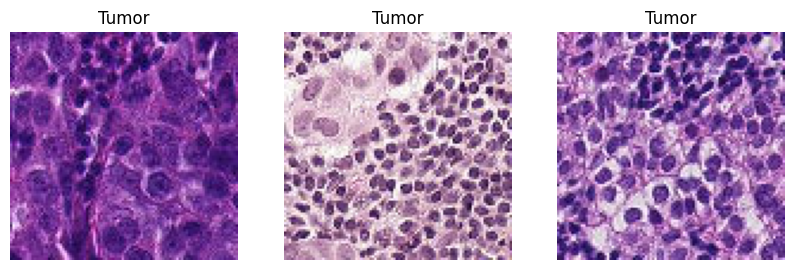

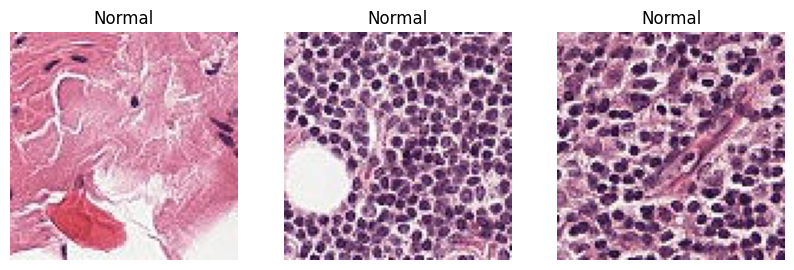

In [12]:
sample_tumor_ids = train_data[train_data['label'] == 1]['id'].sample(n=3).values
sample_normal_ids = train_data[train_data['label'] == 0]['id'].sample(n=3).values

tumor_images = []
for id in sample_tumor_ids:
    image_path = os.path.join(train_path, id + '.tif')  
    tumor_images.append(Image.open(image_path))
    
normal_images = []
for id in sample_normal_ids:
    image_path = os.path.join(train_path, id + '.tif') 
    normal_images.append(Image.open(image_path))
    
plt.figure(figsize=(10, 3))
for i, image in enumerate(tumor_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Tumor')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 3))
for i, image in enumerate(normal_images):
    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.title('Normal')
    plt.axis('off')
plt.show()

We start by looking at some of the samples. Honestly, even with my pairs of eyes providing a global feature view, I have no idea what differentiate cancerous cells from non-cancerous ones.

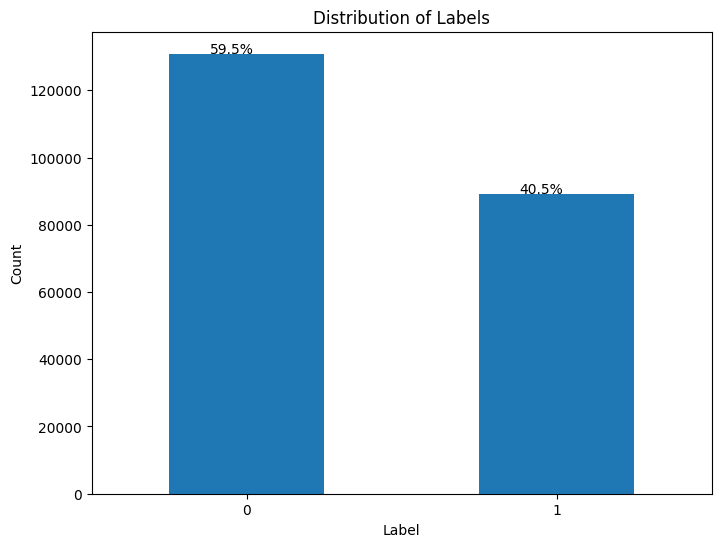

In [4]:
# get count
label_counts = train_data['label'].value_counts()

# histogram
plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# % label
total = len(train_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + total * 0.001
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

The mean of the label column is approximately 0.405, suggesting that about 40.5% of the image patches contain tumor tissue, while the rest do not.
The standard deviation is around 0.491 (from earlier), which indicates a fairly balanced dataset but with a slight imbalance towards non-cancerous samples. This seems acceptable considering the slight imbalance. Also, since the kaggle competition already highlighted a cleaned dataset, we will not need to work on any missing data. 

**Plan of Analysis:**

- Data Preprocessing
    - Updating 'id' Column: Append '.tif' extension to the 'id' column to match filenames with actual image files to correctly map images to their labels during model training.

    - Converting 'Label' to String: Transform the 'label' column to string format, accommodating the requirements of the binary data generators used in Keras, which expect label data in string format for classification tasks.

    - Normalization: Scale image pixel values from the range 0-255 to 0-1. To help in reducing the skewness of pixel values, leading to faster convergence during neural network training.

    - Image Resizing: Downsize images from 96x96 to 64x64 pixels. To speed up the training process without significantly compromising the essential features required for accurate classification. 

    - Batch Size Selection: Opted for a batch size of 256. This size is chosen to balance the need for computational efficiency (larger batches can be processed faster on Kaggle GPUs) and model performance (too large batches might hinder generalization).

Note: Efficiency was catered for some of these because I revisited it and wanted to improve the training time as I was bursting the free limit for GPU on kaggle. I guess a learning point is that such tweaking helps in managing computational resources more efficiently, especially when using GPU with limited memory.



In [6]:
train_data["id"] = train_data["id"].apply(lambda x: x + ".tif")
train_data["label"] = train_data["label"].astype(str)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


In [7]:
datagen = ImageDataGenerator(rescale=1./255.,
                            validation_split=0.2)

In [8]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=256,
    seed=13,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.


In [9]:
valid_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=256,
    seed=13,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 44005 validated image filenames belonging to 2 classes.


**Plan of Analysis**

- Model Building Plan
    - Baseline Model (Model 1): The architecture will include sequential layers of Conv2D, pooling, and dense layers, ending with a sigmoid output for binary classification. This model serves as a benchmark to evaluate the effectiveness of more complex architectures and additional techniques used in the enhanced model.

    - Enhanced Model (Model 2): Incorporates advanced techniques like dropout for regularization, batch normalization for faster and stable training, and Adam optimizer with a specific learning rate for efficient learning. These enhancements are expected to improve the model's ability to generalize and perform better on unseen data.
    
- Subsequent Analysis Plan
    - Evaluate both models using accuracy, loss, and ROC-AUC. Accuracy provides a straightforward metric of performance, loss offers insight into the model’s learning process, and ROC-AUC is particularly useful for binary classification tasks in this slightly imbalanced dataset.

# Model Architecture

**Model 1: Baseline Model**
This will be a baseline CNN model with basic architecture:
- Architecture: Input → Conv2D (filter=16) → Conv2D (filter=16) → MaxPool → Conv2D (filter=32) → Conv2D (filter=32) → AveragePool → Flatten → Dense → Output (Sigmoid)
- Normalization: Pre-training normalization of images by dividing pixel values by 255.
- Output Layer Activation: Sigmoid, suitable for binary classification.
- Batch Size: 256 as explained above.
- Image Target Size: 64x64 (original 96x96). Explained above.
- Epochs: 5 epochs for training to reduce training time while standardising across both models.
- Loss Function: Binary cross-entropy.
- Performance Metrics: Accuracy and ROC-AUC curve.

**Model 2: Enhanced Model**
This model includes several enhancements for better performance and generalization:

- All features of Model 1
- Dropout: Set at 0.1 to reduce overfitting by randomly setting a fraction of input units to 0 at each update during training.
- Batch Normalization: Helps in stabilizing and speeding up the training.
- Optimizer: Adam with a learning rate of 0.001. Adam is efficient, and a smaller learning rate ensures more precise updates, reducing the chance of overshooting the minimum.
- Hidden Layer Activations: ReLU (Rectified Linear Unit), which helps with faster convergence and reduces the likelihood of vanishing gradients.
- Additional Hyperparameters Tuning: In addition, after reviewing model 1, we will experiment with some changes to hyperparamters to improve on model 1 (e.g. filters, kernel size, no. of convo layers). 

The key difference between the two models lies in the addition of Batch Normalization, Dropout, and ReLU activation in Model 2, making it more sophisticated and potentially more capable of handling overfitting than Model 1 and in identnfying cancerous tissues for the problem.

- Dropout for Regularization: Dropout at a rate of 0.1 helps prevent overfitting by randomly deactivating certain neurons, encouraging the model to learn generalized features rather than overly relying on specific training data aspects. This is crucial for medical imaging, where models must perform well on unseen data.

- Batch Normalization for Stability: Batch normalization stabilizes the training by normalizing layer inputs, maintaining a consistent distribution throughout training. This stability is vital in medical image analysis for achieving reliable and precise models.

- ReLU Activation for Complexity: ReLU activation introduces necessary non-linearity, enabling the model to capture complex patterns in medical images. It also mitigates the vanishing gradient problem, facilitating the training of deeper networks.

- Adam Optimizer for Efficiency: Adam optimizer, efficient in sparse gradient handling and adaptive in learning rate adjustment, suits medical image analysis well. It ensures precise and optimal updates during training, crucial for capturing fine details in medical diagnostics.

**Note: 5 epochs will be standardised across all models due to the GPU limit.**

Additional Resources:
- https://www.baeldung.com/cs/ml-relu-dropout-layers
- https://www.linkedin.com/pulse/ways-improve-your-deep-learning-model-batch-adam-albuquerque-lima/

# Results and Analysis

With the architecture laid out, we will proceed to train our model using ROC as the metrics. 

In [10]:
model1_ROC = tf.keras.metrics.AUC()

model1 = Sequential()
    
model1.add(Conv2D(filters=16, kernel_size=(3,3)))
model1.add(Conv2D(filters=16, kernel_size=(3,3)))
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32, kernel_size=(3,3)))
model1.add(Conv2D(filters=32, kernel_size=(3,3)))
model1.add(AveragePooling2D(pool_size=(2,2)))

model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))
    
model1.build(input_shape=(32, 64, 64, 3))
    
model1.compile(loss='binary_crossentropy', metrics=['accuracy', model1_ROC])
    
model1.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (32, 62, 62, 16)          448       

                                                                 

 conv2d_1 (Conv2D)           (32, 60, 60, 16)          2320      

                                                                 

 max_pooling2d (MaxPooling2  (32, 30, 30, 16)          0         

 D)                                                              

                                                                 

 conv2d_2 (Conv2D)           (32, 28, 28, 32)          4640      

                                                                 

 conv2d_3 (Conv2D)           (32, 26, 26, 32)          9248      

                                                                 

 average_pooling2d (Average  (32, 13, 13, 32)          0         

 Pooling2D)                             

In [12]:
his_model1 = model1.fit(
                        train_generator,
                        steps_per_epoch=687,
                        epochs = 5,
                        validation_data = valid_generator,
                        validation_steps=171,
                        verbose=1)

Epoch 1/5

687/687 [==============================] - 1106s 2s/step - loss: 0.5875 - accuracy: 0.7043 - auc: 0.7478 - val_loss: 0.5414 - val_accuracy: 0.7465 - val_auc: 0.8035

Epoch 2/5

687/687 [==============================] - 403s 587ms/step - loss: 0.5452 - accuracy: 0.7404 - auc: 0.7941 - val_loss: 0.5184 - val_accuracy: 0.7588 - val_auc: 0.8187

Epoch 3/5

687/687 [==============================] - 304s 443ms/step - loss: 0.5142 - accuracy: 0.7602 - auc: 0.8196 - val_loss: 0.4865 - val_accuracy: 0.7760 - val_auc: 0.8465

Epoch 4/5

687/687 [==============================] - 301s 438ms/step - loss: 0.4886 - accuracy: 0.7761 - auc: 0.8391 - val_loss: 0.4590 - val_accuracy: 0.7926 - val_auc: 0.8610

Epoch 5/5

687/687 [==============================] - 295s 429ms/step - loss: 0.4769 - accuracy: 0.7814 - auc: 0.8474 - val_loss: 0.4978 - val_accuracy: 0.7710 - val_auc: 0.8568


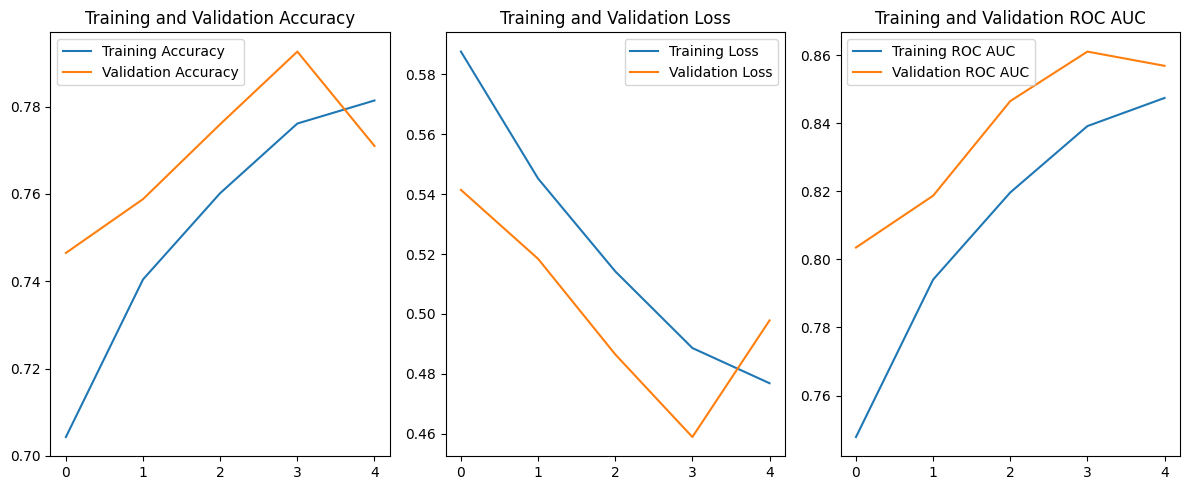

In [14]:

acc = his_model1.history['accuracy']
val_acc = his_model1.history['val_accuracy']
loss = his_model1.history['loss']
val_loss = his_model1.history['val_loss']
roc_auc = his_model1.history['auc']
val_roc_auc = his_model1.history['val_auc']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, roc_auc, label='Training ROC AUC')
plt.plot(epochs, val_roc_auc, label='Validation ROC AUC')
plt.title('Training and Validation ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()


**Model 1 Results**

Training and Validation Accuracy:

The training accuracy improved over the 5 epochs, which indicates that the model is learning and improving its performance on the training data.
The validation accuracy also increased in Epoch 4, before dropping slightly in the final epoch. This suggests the model is generalizing to unseen data, though the drop in the last epoch could be a sign of beginning overfitting or variability in the validation dataset.

Training and Validation Loss:

The training loss decreased consistently, showing that the model is getting better at classifying the training images.
The validation loss decreased until Epoch 4, indicating improving validation performance. However, the increase in validation loss in the final epoch could suggest that the model started to overfit the training data or that there's a variation in the difficulty of the validation set.

Training and Validation ROC AUC:

The ROC AUC for the training set improved, which is a good sign that the model is increasingly able to distinguish between the positive and negative classes.
The validation ROC AUC followed a similar upward trend, peaking at Epoch 4 before a slight decrease in Epoch 5. The high ROC AUC values suggest that the model has a good measure of separability and is able to rank the positive class higher than the negative class with high confidence.

Overall Interpretation:
Model 1 is performing reasonably well on this binary classification task. The metrics show that it is learning as expected, and there is a general improvement in its ability to classify the images correctly. However, the slight decrease in validation accuracy and ROC AUC in the final epoch alongside an increase in validation loss indicates that the model may be starting to overfit the training data, as it's getting more specialized in the training set at the expense of generalization. This is a common phenomenon when the model learns patterns that are too specific to the training data, which don't generalize well to new, unseen data. 

Clearly, with a baseline model, we can see that the performance using CNN is already reasonably well. We will now look at the improvement in architecture for model 2.

# Model 2

In [18]:
model2_ROC = tf.keras.metrics.AUC()

model2 = Sequential()

model2.add(Conv2D(filters=16, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(filters=16, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))

model2.add(Conv2D(filters=32, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(Conv2D(filters=32, kernel_size=(3,3)))
model2.add(BatchNormalization())
model2.add(Activation("relu"))
model2.add(AveragePooling2D(pool_size=(2,2)))
model2.add(Dropout(0.1))

model2.add(Flatten())
model2.add(Dense(1, activation = "sigmoid"))

model2.build(input_shape=(32, 64, 64, 3))

model2.compile(Adam(0.001), loss = "binary_crossentropy", metrics=['accuracy', model2_ROC])

model2.summary()

Model: "sequential_2"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_10 (Conv2D)          (32, 62, 62, 16)          448       

                                                                 

 batch_normalization_6 (Bat  (32, 62, 62, 16)          64        

 chNormalization)                                                

                                                                 

 activation_6 (Activation)   (32, 62, 62, 16)          0         

                                                                 

 conv2d_11 (Conv2D)          (32, 60, 60, 16)          2320      

                                                                 

 batch_normalization_7 (Bat  (32, 60, 60, 16)          64        

 chNormalization)                                                

                                                                 

 activation_7 (Activation)   (32, 60, 

In [19]:
his_model2 = model2.fit(
                        train_generator, 
                        steps_per_epoch=687, 
                        epochs=5,
                        validation_data=valid_generator,
                        validation_steps=171,
                        verbose=1)

Epoch 1/5


2023-12-09 21:29:13.827693: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


687/687 [==============================] - 322s 464ms/step - loss: 0.3917 - accuracy: 0.8302 - auc_2: 0.9000 - val_loss: 0.3790 - val_accuracy: 0.8408 - val_auc_2: 0.9081

Epoch 2/5

687/687 [==============================] - 299s 436ms/step - loss: 0.3345 - accuracy: 0.8587 - auc_2: 0.9289 - val_loss: 0.5707 - val_accuracy: 0.7783 - val_auc_2: 0.8949

Epoch 3/5

687/687 [==============================] - 302s 439ms/step - loss: 0.3019 - accuracy: 0.8745 - auc_2: 0.9421 - val_loss: 0.5196 - val_accuracy: 0.7879 - val_auc_2: 0.8948

Epoch 4/5

687/687 [==============================] - 297s 433ms/step - loss: 0.2809 - accuracy: 0.8846 - auc_2: 0.9499 - val_loss: 0.3827 - val_accuracy: 0.8448 - val_auc_2: 0.9208

Epoch 5/5

687/687 [==============================] - 295s 429ms/step - loss: 0.2656 - accuracy: 0.8916 - auc_2: 0.9551 - val_loss: 0.4534 - val_accuracy: 0.8197 - val_auc_2: 0.8943


In [22]:
print(his_model2.history.keys())

dict_keys(['loss', 'accuracy', 'auc_2', 'val_loss', 'val_accuracy', 'val_auc_2'])


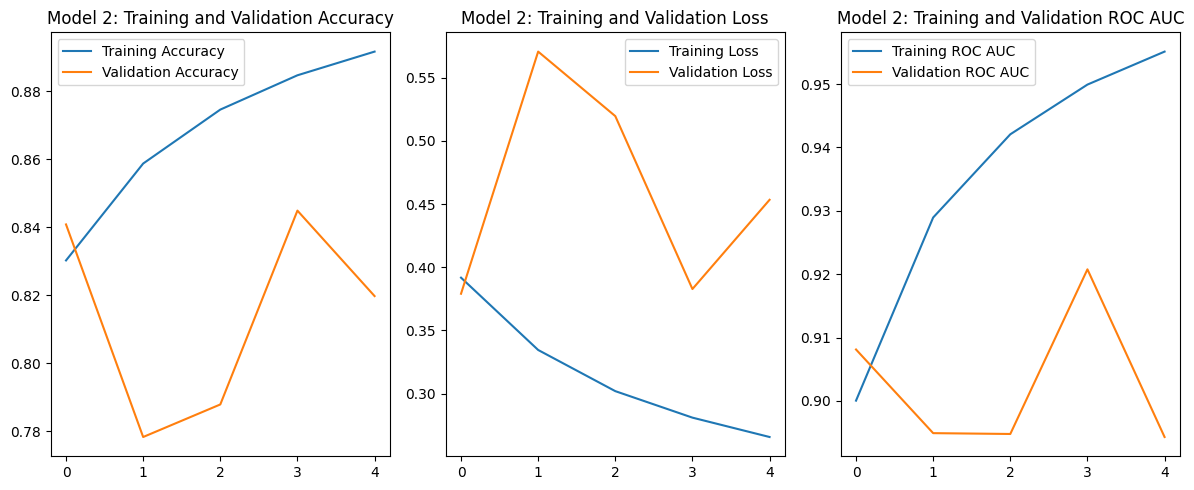

In [23]:
acc2 = his_model2.history['accuracy']
val_acc2 = his_model2.history['val_accuracy']
loss2 = his_model2.history['loss']
val_loss2 = his_model2.history['val_loss']
roc_auc2 = his_model2.history['auc_2']
val_roc_auc2 = his_model2.history['val_auc_2']

epochs = range(len(acc))

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc2, label='Training Accuracy')
plt.plot(epochs, val_acc2, label='Validation Accuracy')
plt.title('Model 2: Training and Validation Accuracy')
plt.legend()

# loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss2, label='Training Loss')
plt.plot(epochs, val_loss2, label='Validation Loss')
plt.title('Model 2: Training and Validation Loss')
plt.legend()

# ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, roc_auc2, label='Training ROC AUC')
plt.plot(epochs, val_roc_auc2, label='Validation ROC AUC')
plt.title('Model 2: Training and Validation ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()

**Model 2**

As expected, Model 2 shows a significant improvement over Model 1 in several key areas:
- Training Accuracy: Model 2 starts at a higher accuracy and shows a steady increase throughout the epochs, suggesting that the model's enhancements are effective at learning from the training data.
- Validation Accuracy: While there is an initial improvement in validation accuracy, we see a decline in the final epoch, indicating possible overfitting to the training data or variability in the validation dataset.
- Training and Validation Loss: Model 2's training loss decreases more consistently and to a lower value than Model 1, indicating better learning. However, similar to Model 1, the validation loss for Model 2 increases after a certain point, reinforcing the overfitting concern.
- ROC AUC: Model 2's ROC AUC on training data shows a promising upward trend, but the validation ROC AUC fluctuates, suggesting that the model might be capturing noise along with relevant features and also indicating signs of overfitting again.

**Comparison with Model 1:**
With the improved architecture, Model 2 outperforms Model 1 in terms of both training and validation accuracy, as well as ROC AUC, confirming the benefits of additional features like dropout and batch normalization. Both models display a pattern where validation loss and accuracy begin to diverge from training performance, pointing to overfitting as training progresses. 

With that, I decided to see how we can further enhance Model 2 through Model 3, especially in dealing with overfitting and slight drop in performance during the final epoch.

# Model 3

Design Changes in Model 3:
- Increased Dropout: The dropout rate was increased to 0.3 from 0.1 in Model 2 to provide stronger regularization and prevent overfitting.
- L2 Regularization: Model 3 introduces L2 regularization in the convolutional and dense layers. This penalizes large weights, encouraging the model to maintain smaller weights, which can lead to simpler models that generalize better.
- Reduced Learning Rate: The learning rate was decreased to 0.0001, allowing for finer adjustments to the weights and potentially avoiding local minima that could negatively impact generalization.
- Early Stopping: To avoid overfitting as seen in Models 1 and 2, early stopping with restoration of the best weights ensures that Model 3 stops training when the validation loss starts to increase, rather than continuing to learn noise.
- Adaptive Learning Rate: By incorporating ReduceLROnPlateau, Model 3 can dynamically adjust the learning rate during training, providing an opportunity for the model to recover from potential overfitting and refine its learning from the data.

These changes aim to address the specific issues identified in the previous models and leverage the understanding gained to enhance Model 3's performance, especially its ability to generalize to new unseen data.

Additional Resources:
https://medium.com/@himanshuit3036/is-your-epochs-not-performing-try-callbacks-76519f0368a9#:~:text=Using%20EarlyStopping%20we%20can%20stop,not%20decreasing%20for%20some%20time.

In [24]:
train_generator_2 = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=64,
    seed=13,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 176020 validated image filenames belonging to 2 classes.


In [25]:
valid_generator2 = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=64,
    seed=13,
    class_mode="binary",
    target_size=(64,64),
    shuffle=True)

Found 44005 validated image filenames belonging to 2 classes.


In [27]:
from keras.regularizers import l2

model3_ROC = tf.keras.metrics.AUC()

model3 = Sequential()

reg = l2(0.001)  

model3.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', kernel_regularizer=reg))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Conv2D(filters=16, kernel_size=(3,3), kernel_regularizer=reg))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Dropout(0.3))

model3.add(Conv2D(filters=32, kernel_size=(3,3), kernel_regularizer=reg))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(Conv2D(filters=32, kernel_size=(3,3), kernel_regularizer=reg))
model3.add(BatchNormalization())
model3.add(Activation("relu"))
model3.add(AveragePooling2D(pool_size=(2,2)))
model3.add(Dropout(0.3))

model3.add(Flatten())
model3.add(Dense(1, activation="sigmoid", kernel_regularizer=reg))

model3.build(input_shape=(32, 64, 64, 3))

model3.compile(Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=['accuracy', model2_ROC])

model3.summary()

Model: "sequential_4"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 conv2d_18 (Conv2D)          (32, 62, 62, 16)          448       

                                                                 

 batch_normalization_14 (Ba  (32, 62, 62, 16)          64        

 tchNormalization)                                               

                                                                 

 activation_14 (Activation)  (32, 62, 62, 16)          0         

                                                                 

 conv2d_19 (Conv2D)          (32, 60, 60, 16)          2320      

                                                                 

 batch_normalization_15 (Ba  (32, 60, 60, 16)          64        

 tchNormalization)                                               

                                                                 

 activation_15 (Activation)  (32, 60, 

In [29]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
his_model3 = model3.fit(
                    train_generator_2, 
                    steps_per_epoch=2750, 
                    validation_data=valid_generator2,
                    validation_steps=687,
                    epochs=5,
                    callbacks=[reduce, earlystopper])

Epoch 1/5


2023-12-09 22:04:03.255454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


2750/2750 [==============================] - 315s 113ms/step - loss: 0.5025 - accuracy: 0.8053 - auc_2: 0.8767 - val_loss: 0.4494 - val_accuracy: 0.8365 - val_auc_2: 0.9071 - lr: 1.0000e-04

Epoch 2/5

2750/2750 [==============================] - ETA: 0s - loss: 0.4471 - accuracy: 0.8320 - auc_2: 0.9034

Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

2750/2750 [==============================] - 306s 111ms/step - loss: 0.4471 - accuracy: 0.8320 - auc_2: 0.9034 - val_loss: 0.5336 - val_accuracy: 0.7962 - val_auc_2: 0.9234 - lr: 1.0000e-04

Epoch 3/5

2750/2750 [==============================] - ETA: 0s - loss: 0.4222 - accuracy: 0.8408 - auc_2: 0.9142

Epoch 3: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Restoring model weights from the end of the best epoch: 1.

2750/2750 [==============================] - 319s 116ms/step - loss: 0.4222 - accuracy: 0.8408 - auc_2: 0.9142 - val_loss: 0.4808 - val_accuracy: 0.8190 - val_auc_2: 0.9243 -

In [30]:
print(his_model3.history.keys())

dict_keys(['loss', 'accuracy', 'auc_2', 'val_loss', 'val_accuracy', 'val_auc_2', 'lr'])


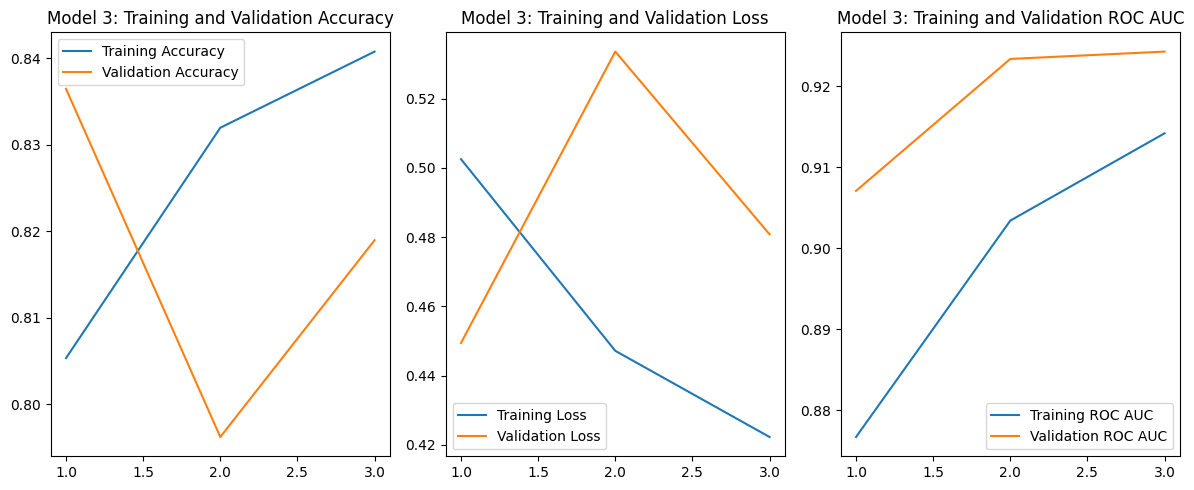

In [33]:
acc3 = his_model3.history['accuracy']
val_acc3 = his_model3.history['val_accuracy']
loss3 = his_model3.history['loss']
val_loss3 = his_model3.history['val_loss']
roc_auc3 = his_model3.history['auc_2']
val_roc_auc3 = his_model3.history['val_auc_2']

epochs = range(1,4)

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc3, label='Training Accuracy')
plt.plot(epochs, val_acc3, label='Validation Accuracy')
plt.title('Model 3: Training and Validation Accuracy')
plt.legend()

# loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss3, label='Training Loss')
plt.plot(epochs, val_loss3, label='Validation Loss')
plt.title('Model 3: Training and Validation Loss')
plt.legend()

# ROC AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, roc_auc3, label='Training ROC AUC')
plt.plot(epochs, val_roc_auc3, label='Validation ROC AUC')
plt.title('Model 3: Training and Validation ROC AUC')
plt.legend()

plt.tight_layout()
plt.show()

**Model 3**

- Model 3's training accuracy showed consistent improvement, while validation accuracy diverged later on, suggesting initial learning with potential overfitting.
- The training loss decreased over epochs, but validation loss increased after the first epoch, triggering early stopping and hinting at overfitting. 
- Both training and validation ROC AUC are high, with the training AUC showing a slight upward trend and the validation AUC remaining relatively flat. This indicates the model has good class separation ability.

Comparison with earlier models:
- Model 3 began with better accuracy and AUC than Model 1, benefiting from the additional enhancements.
- Despite a strong start, Model 3 only has a minute improvement (ROC) over Model 2's results due to early stopping, which prevented potential overfitting seen in Model 2.
- The enhancements made in Model 3, such as increased dropout, L2 regularization, and a reduced learning rate, along with the addition of early stopping and learning rate reduction on plateau, appear to have had a mixed impact:
    - Increased Dropout (0.3) and L2 Regularization were intended to reduce overfitting. While these measures typically help generalize better, we still observe some signs of overfitting, as the validation accuracy and loss did not improve consistently.
    - Reduced Learning Rate (0.0001) and dynamic adjustments with ReduceLROnPlateau were supposed to provide a more refined learning process. The learning rate reductions did occur as intended when the validation loss did not improve, which is a sign that the callbacks worked as expected.
    - Early Stopping was correctly triggered, indicating that the model wasn't benefiting from further training epochs beyond the third, which suggests that the model quickly reached its performance capacity with the current architecture and data.

Summary:
Model 3's early stopping indicates it is the most regularized model, potentially making it the most robust to overfitting and therefore possibly the best candidate for validation on the test data. However, the increase in validation loss after the first epoch suggests there may still be room for improvement, such as further tuning the regularization strength or exploring other techniques to enhance generalization. Given that we restrict epoch to 5 due to GPU constraint and standardise it across all models, we would not be able to explore reducing learning rate while increasing epochs. On the other hand, given that Model 3's performance did not degrade as much as Model 2's in later epochs, and it has higher regularization, it could be considered a better model for final validation on test data. In this sense, it represents a conservative approach, favoring the prevention of overfitting and potentially offering more reliable performance on unseen data.

# Test Results

In [34]:
test_data = pd.DataFrame({'id':os.listdir(test_path)})
test_data.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [35]:
datagen_test = ImageDataGenerator(rescale=1./255.)

test_generator = datagen_test.flow_from_dataframe(
    dataframe=test_data,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [36]:
results = model3.predict(test_generator, verbose=1)

57458/57458 [==============================] - 352s 6ms/step


In [37]:
results = np.transpose(results)[0]
submission_df = pd.DataFrame()
submission_df['id'] = test_data['id'].apply(lambda x: x.split('.')[0])
submission_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, results))
submission_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [38]:
submission_df.to_csv('submission.csv', index=False)

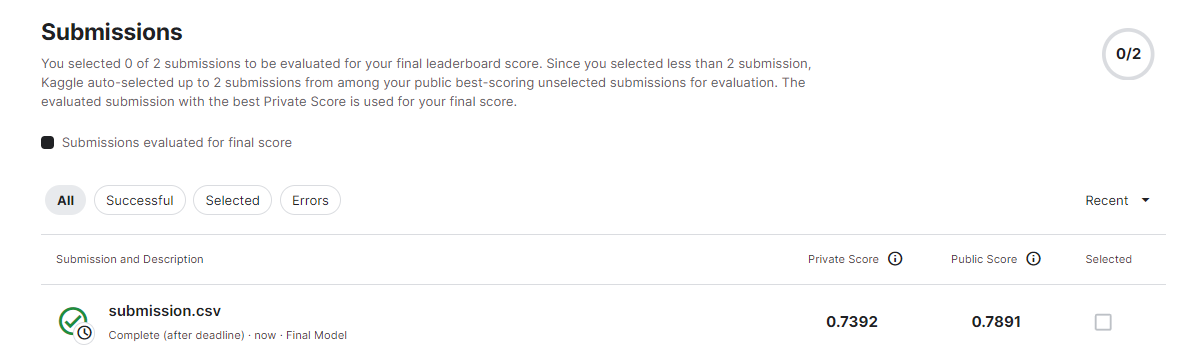

Considering the self-limitation of 5 epochs, I thought that the model architecture enhancement in model 3 really indicated a decent validation score for the test data. Clearly, increasing epochs and reducing learning rates and other parameters could have lead to a slower learning rate that would reduce overfitting more. However, considering the 5 epochs limitation, I thought that the step by step improvement from model 1 to 3 really shows how hyperparameter fine-tuning and architecture enhancement can improve CNN modeling.

# Takeaway

- What Helped Improve Model Performance:

    - Batch Normalization: This enhancement appeared to stabilize training across models, helping each learn more effectively from the training data.

    - Dropout: Increasing the dropout rate in Model 2 and then dropping to 0.3 in model 3 did provide a regularization effect, though it was not sufficient alone to prevent overfitting as indicated by the validation loss increase.

    - L2 Regularization: The inclusion of L2 regularization likely contributed to the prevention of overfitting by penalizing large weights, but its impact needs to be evaluated in conjunction with other regularization techniques.

    - Reduced Learning Rate and Dynamic Adjustments: Starting with a lower learning rate and adjusting it dynamically helped prevent drastic updates that could derail the training process, although it may have also slowed down the learning due to the 5 epoch limitation.

    - Early Stopping: This callback prevented unnecessary training beyond the point of performance improvement, saving computational resources and potentially preventing further overfitting. It does seem counter-intuitive but it really strikes me when i see the performance drop in model 2 later epochs.

- What Did Not Help or Could Be Improved:

    - Learning Rate Too High with low epoch count: While a better learning rate will help the model to learn faster, it is clear that overfitting is present throughout the 3 models. Slowing down learning rate and increasing epochs will prevent overshooting during optimization. Indeed, finding the right balance is crucial.

    - Overfitting Still an Issue: Despite regularization efforts, overfitting remained a challenge, as seen by the increase in validation loss after initial improvement. This indicates that the models were still learning some noise from the training data. 

- Future Improvements to Explore:

    - Data Augmentation: To further combat overfitting and enhance generalization, more sophisticated data augmentation techniques could be employed, providing the model with a more varied and extensive set of training examples.

    - Hyperparameter Optimization: Automated hyperparameter tuning techniques, such as grid search or Bayesian optimization, could systematically explore the hyperparameter space to find more optimal settings. 

    - Advanced Architectures: Exploring more complex or deeper architectures, possibly with residual connections or different types of layers like depthwise separable convolutions, could improve feature extraction capabilities. Although they could also lead to overshooting with the complex modeling. I did read about them below but did not ventured into these more complex modeling architectures.

    - Transfer Learning: Something I saw done really well in other kagglers' notebooks post-assignment is that a lot of pre-trained models were very effective as a starting point. Leveraging pre-trained models on similar tasks could provide a more robust starting point for feature learning, which may improve performance, especially when training data is limited.

- Data augmentation: https://nnart.org/what-is-data-augmentation-in-a-cnn/
- Different convolutions: https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215
- Transfer Learning: https://www.kaggle.com/code/qitvision/a-complete-ml-pipeline-fast-ai